# Investigating Fandango Movie Ratings
The goal of this project is to analyze Fandango's movie ratings data to determine whether the website is inflating its rating scores.

The project arises from a 2015 article by data journalist, Wat Hickey, whose article found strong evidence to suggest that Fandango's rating system was biased and dishonest. Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible.

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

In [64]:
import warnings

warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
import re


### Understanding the Data
In order to determine whether there's been any change in Fandango's rating system since the Hickey article, we will compare the system's characteristics before and after the analysis.

The fandango_score dataset represents the previous system characteristics while the movie_ratings dataset represents the system characteristics after the bug fix should have taken place.

In [37]:
fandango_score = pd.read_csv('fandango_score_comparison.csv')
movie_ratings = pd.read_csv('movie_ratings_16_17.csv')

fandango_score.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [38]:
movie_ratings.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


We'll isolate the columns in both datasets that are relevant for our analysis.

In [39]:
fandango_score = fandango_score[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]

movie_ratings = movie_ratings[['movie', 'year', 'fandango']]

In [40]:
fandango_score.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [41]:
movie_ratings.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


The population of interest for our analysis comprises __ALL__ the movie ratings stored on Fandango's website, regardless of the releasing year. Because we're conducting a comparative analysis, our analysis of the population will be broken down into 2 timeframes: before the article *and* after the article.

However, the fandango_score dataset, representing ratings from before the article, contains only ratings information for films that meet specific criteria:
* They were on Fandango's *'movies in theater'* page on August 24, April 6 and June 29
* They had tickets on sale on said dates; and
* They had over 30 user reviews.
This creates a sampling problem as the criteria may be too restrictive / specific to allow for adequate random sampling for the time period.

Generally, adequate statistical analysis requires that our samples be representative of their corresponding populations. This means that each individual in the population has an equal chance of selection in our samples. Random sampling ensures that any estimate / statistic derived from the dataset will have a low sampling error, i.e. will be very close to the population value.

The criteria restrictions in Hickey's dataset means that many movie records are not represented, including:
* movies from outside the specified dates,
* movies with under 30 user reviews; and
* movies without tickets on the specified dates.

### Changing the Goal of our Analysis
Due to the issue stated above, and the time implications of sourcing and collecting new data for the analysis, we will amend the goal of our analysis to reflect the data that we have.

### New Project Goal
We'll analyze movie ratings from 2016 to determine whether Fandango is still inflating its rating scores for popular movies, as it did in 2015.

### Isolating the Samples We Need
With the new goal, we now have two populations that we want to describe and compare with each other:
* All Fandango's ratings for popular movies released in 2015.
* All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague, and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

Let's check both datasets for popular reviews. We know the fandango_score dataset has popular movies. We'll check the movie_ratings dataset.

In [42]:
movie_ratings.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


The movie_ratings dataset doesn't provide information about the number of ratings. We can check the representative nature of the dataset is to randomly sample 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [43]:
movie_ratings.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As of April 2018, all but 1 movie in our sample had rating count in excess of our popular movie criteria.

In [44]:
(fandango_score['Fandango_votes'] < 30).sum()

0

Our previous dataset also meets our popular movie criteria.

Since we will be working with specific years (2015, 2016), we need to clean the dataset to remove any movies outside this range.

In [45]:
fandango_score.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


Year is a part of the 'FILM' variable. We'll extract it into its own variable.

In [61]:
pattern = r"(\(\d+\))"
pattern_2 = r'(\(|\))'
fandango_score['Year'] = fandango_score['FILM'].str.extract(pattern)
fandango_score['Year'] = fandango_score['Year'].str.replace(pattern_2, '').astype(int)
fandango_score['Year'].head()

0    2015
1    2015
2    2015
3    2015
4    2015
Name: Year, dtype: int64

We'll now isolate the movies for the relevant years from each dataset.

In [62]:
movies_2015 = fandango_score.loc[fandango_score['Year'] == 2015]
movies_2016 = movie_ratings.loc[movie_ratings['year'] == 2016]

In [63]:
movies_2015.sample(15, random_state=0)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
48,Fantastic Four (2015),3.0,2.7,6288,0.3,2015
31,When Marnie Was There (2015),4.5,4.1,46,0.4,2015
123,Magic Mike XXL (2015),4.5,4.4,9363,0.1,2015
59,Mortdecai (2015),3.5,3.2,1196,0.3,2015
9,Love & Mercy (2015),4.5,4.0,864,0.5,2015
138,Spare Parts (2015),4.5,4.5,450,0.0,2015
52,The Age of Adaline (2015),4.5,4.2,3325,0.3,2015
120,The Wolfpack (2015),3.5,3.4,66,0.1,2015
85,Little Boy (2015),4.5,4.3,811,0.2,2015
8,Shaun the Sheep Movie (2015),4.5,4.0,896,0.5,2015


In [59]:
movies_2016.sample(15, random_state=0)

,movie,year,fandango
121,Nerve,2016,4.0
83,Jane Got a Gun,2016,3.5
179,The Great Wall,2016,4.0
108,Mechanic: Resurrection,2016,4.0
136,Resident Evil: The Final Chapter,2016,4.0
80,Inferno,2016,3.5
22,Ben-Hur,2016,4.0
137,Ride Along 2,2016,4.0
160,The Angry Birds Movie,2016,4.0
8,Allied,2016,4.0


### Comparing Distribution Shapes for 2015 and 2016
We'll make a high-level comparison between the shapes of the distributions of movie ratings for both samples.

Analyze the two kernel density plots. Try to answer the following questions:

What is the shape of each distribution?
How do their shapes compare?
If their shapes are similar, is there anything that clearly differentiates them?
Can we see any evidence on the graph that suggests that there is indeed a change between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016?
Provided there's a difference, can we tell anything about the direction of the difference? In other words, were movies in 2016 rated lower or higher compared to 2015?

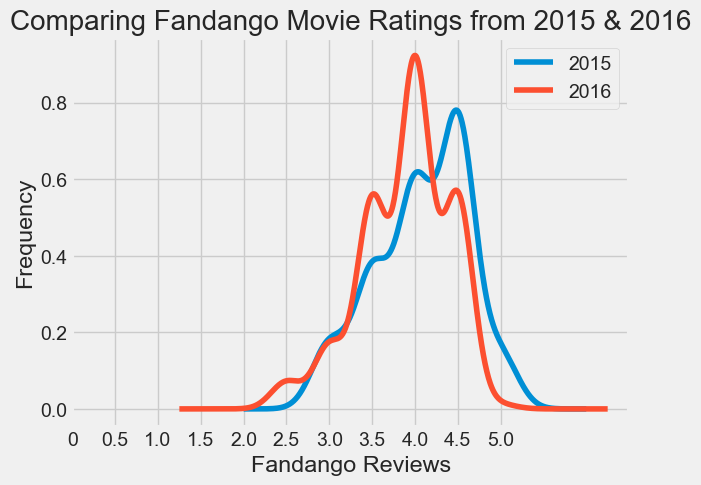

In [71]:
plt.style.use('fivethirtyeight')

movies_2015['Fandango_Stars'].plot.kde(label=2015, legend=True)
movies_2016['fandango'].plot.kde(label=2016, legend=True)
plt.xticks(ticks=np.arange(0, 5.1, 0.5), labels=[0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlabel('Fandango Reviews')
plt.ylabel('Frequency')
plt.title(label='Comparing Fandango Movie Ratings from 2015 & 2016', fontsize=20)
plt.legend()
plt.show()

From the chart above, we can deduce the following:
* Both distibutions are right skewed. Neither have ratings below 2.0
* However, the 2015 distribution is more right-skewed than the 2016 distribution, which has a slightly normal distribution.
* We see the mode of the 2016 distribution move leftward hovering at the 4.0 rating, compared to the 2015 distribution, whose mode is 4.5.
* We can estimate that the mean and median of the 2016 distribution is between 3.7 and 4.0. These are less than the 2015 median and mode
* These visual differences tell us that the 2016 distribution is moving leftward away from the 2015 distribution.

In [78]:
mean_2015 = movies_2015['Fandango_Stars'].mean()
median_2015 = movies_2015['Fandango_Stars'].median()

mean_2016 = movies_2016['fandango'].mean()
median_2016 = movies_2016['fandango'].median()

print('2015 average rating: ', mean_2015, '\n',
      '2015 median rating: ', median_2015, '\n',
      '2016 average rating: ', mean_2016, '\n',
      '2016 median rating: ', median_2016)

2015 average rating:  4.0852713178294575 
 2015 median rating:  4.0 
 2016 average rating:  3.887434554973822 
 2016 median rating:  4.0


### Comparing Relative Frequencies
The kernel density plots above showed that there's a clear difference between the two distributions. They also provided us with information about the direction of the difference: movies in 2016 were rated slightly lower than those in 2015.

We now need to analyze more granular information. We'll examine the frequency distribution tables of the two distributions. Since the samples have different number of movies, it would make better sense to compare using relative frequencies.

We'll compare using percentages for more clarity.

In [82]:
movies_2015['Fandango_Stars'].value_counts(normalize=True).sort_index() * 100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [83]:
movies_2016['fandango'].value_counts(normalize=True).sort_index() * 100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

Our analysis from the kernel density plot is confirmed by the relative frequency distributions. The most frequent value in 2016 is 4.0, as opposed to 4.5 the year before. In 2016, 3.5 and 4.0 saw increased frequency, every other value had lower frequencies that the preceding year. Also, 2016 saw the inclusion of a new low rating: 2.5.

The ratings from 2016 is clearly moving away from higher numbers toward more centered and even lower numbers.

### Determining the Direction of the Change
We've confirmed with the two tables before that there is indeed a clear difference between the two distributions.

We'll take a couple of summary statistics to get a more precise picture about the direction of the difference. We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [90]:
mean_2015 = movies_2015['Fandango_Stars'].mean()
median_2015 = movies_2015['Fandango_Stars'].median()
mode_2015 = movies_2015['Fandango_Stars'].mode()[0]

print('2015 average rating: ', mean_2015, '\n',
      '2015 median rating: ', median_2015, '\n',
      '2015 most frequent rating: ', mode_2015)

2015 average rating:  4.0852713178294575 
 2015 median rating:  4.0 
 2015 most frequent rating:  4.5


In [91]:
mean_2016 = movies_2016['fandango'].mean()
median_2016 = movies_2016['fandango'].median()
mode_2016 = movies_2016['fandango'].mode()[0]

print('2016 average rating: ', mean_2016, '\n',
      '2016 median rating: ', median_2016, '\n',
      '2016 most frequent rating: ', mode_2016)

2016 average rating:  3.887434554973822 
 2016 median rating:  4.0 
 2016 most frequent rating:  4.0


These metrics confirms the previous assessments of the leftward move of the ratings on Fandango's website. Although, these metrics show that the move is only slight as the median rating of both distributions remains 4.0 and the mean only changes by 0.12 points.

We'll generate a grouped bar plot to show comparatively how the mean, median, and mode varied for 2015 and 2016.

In [96]:
movies_stats = pd.DataFrame({'2015':[mean_2015, median_2015, mode_2015], '2016':[mean_2016, median_2016, mode_2016]}, index=['mean', 'median', 'mode'])

movies_stats

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


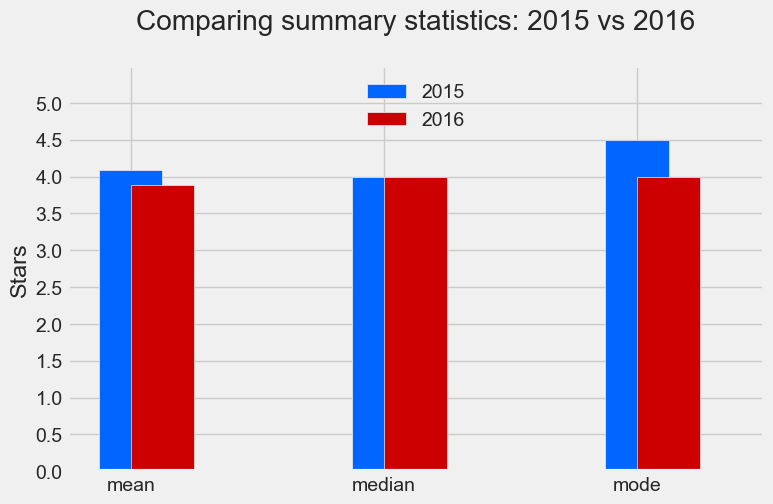

In [98]:
plt.style.use('fivethirtyeight')
movies_stats['2015'].plot.bar(color='#0066FF', align='center', label='2015', width=.25)
movies_stats['2016'].plot.bar(color='#CC0000', align='edge', label='2016', width=.25, rot=0, figsize=(8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y=1.07)
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha=0, loc='upper center')
plt.show()

### Conclusion
We can conclude that Fandango's 2016 ratings are less inflated than the 2015 ratings.

### Next Steps
These are a few next steps to consider:
* Customizing the graphs by reproducing almost completely the FiveThirtyEight style.
* Improving the project from a stylistical point of view
* Using the two samples to compare ratings of different movie ratings aggregators and recommend what's the best website to check for a movie rating.
* Collecting recent movie ratings data and formulating research questions.